# Comparison of Explicit and Implicit Schemes for Simulating Transient Water Flow in a Porous Medium

## Overview

This Jupyter notebook is designed to demonstrate the differences between explicit and implicit numerical schemes for solving the governing equation of transient water flow in a discretized porous medium. We aim to provide a comprehensive understanding of how each scheme works, their respective strengths and weaknesses, and under what conditions one might be preferred over the other.

## Objectives

- To build a simple simulator based on an explicit numerical scheme.
- To build a simple simulator based on an implicit numerical scheme.
- To compare the two approaches in terms of computational efficiency, stability, and accuracy.

## Structure of the Notebook

1. **Introduction and Theoretical Background**
    - Governing Equation
    - Time Discretization for Explicit and Implicit Schemes
    - Algorithmic Steps for Numerical Solution

2. **Setup and Initial Conditions**
    - Importing Libraries
    - Defining Constants and Initial Conditions

3. **Explicit Scheme Simulator**
    - Algorithm Implementation
    - Running the Simulation
    - Results and Discussion

4. **Implicit Scheme Simulator**
    - Algorithm Implementation
    - Running the Simulation
    - Results and Discussion

5. **Comparative Analysis**
    - Stability and Time Step Sensitivity
    - Computational Efficiency
    - Accuracy Assessment

6. **Conclusion and Recommendations**

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Introduction and Theoretical Background

### Governing Equation for Transient Water Flow in a Discretized Porous Medium

The transport of fluid, particularly water, through porous media is a critical process in various applications ranging from reservoir engineering to environmental science. In this context, a discretized representation of a porous medium is often employed for numerical simulation. The mathematical model for transient water flow in such a medium is encapsulated in the following partial differential equation (PDE):

$$
\begin{equation}
\underbrace{\Big[\Phi_{\text{ref}} V \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right) \frac{dp}{dt} \Big]_i}_{\text{Transient term in block }i, \, \left[\frac{m^3}{s} \right]}
+ \underbrace{\sum_{j \in C(i)} \left[ \left[b(p) \lambda m_T(p) \right]_i T_{ij} (p_{i} - p_{j}) \right]}_{\text{Flow between connected blocks}, \, \left[\frac{m^3}{s} \right]}
+ \underbrace{T_{w,i}M_{i} (p_i - p_{bhp,w})}_{\text{Inflow into well within block }i, \, \left[\frac{m^3}{s} \right]} = 0
\end{equation}
$$

The equation comprises three primary components:

1. **Transient Term**: This term accounts for the changes in fluid storage within a discrete block $ i $, captured through variables like pore volume multiplier $ m_\phi $, formation volume factor $ b $, and the rate of pressure change $ \frac{dp}{dt} $.

2. **Inter-Block Flow Term**: This term describes the fluid exchange between connected blocks $ i $ and $ j $, influenced by the transmissibility $ T_{ij} $ and pressure difference $ p_i - p_j $.

3. **Well Inflow Term**: This term quantifies the influence of a wellbore within block $ i $, contributing to the inflow or outflow based on the pressure difference between the cell and the well's bottomhole pressure $ p_{bhp,w} $.

### Initial Conditions

To solve this equation in a time-dependent context, initial conditions are indispensable. We assume a spatially homogeneous initial condition, with constant pressure $ p_i = \text{const} $ prevailing across all cells $ i $.

### Nomenclature with Units

- $ \Phi_{\text{ref,i}} $: Reference porosity in cell $ i $, dimensionless.
- $ V_i $: Volume of cell $ i $, $ m^3 $.
- $ m_{\phi,i} $: Pore volume multiplier in cell $ i $, dimensionless.
- $ b_i $: Formation volume factor; essentially a ratio relating the volume of fluid in reservoir conditions to that at surface conditions, $ m^3/m^3 $.
- $ C(i) $: Set of cells directly connected to cell $ i $.
- $ \lambda $: Mobility of the water phase, $ m^2/\text{Pa} \cdot s $.
- $ m_{T,i} $: Transmissibility multiplier in cell $ i $, dimensionless.
- $ T_{ij} $: Transmissibility factor between cells $ i $ and $ j $, $ m^2/\text{Pa} \cdot s $.
- $ p_i $: Pressure in cell $ i $, Pa.
- $ T_{w,i} $: Transmissibility of the well connection in cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ M_{i} $: Mobility of the water phase in the well connection at cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ p_{bhp,w} $: Bottomhole pressure of the well, Pa.

### 1. Transient Term in Block $i$

$$
\underbrace{\Big[\Phi_{\text{ref}} V \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right) \frac{dp}{dt} \Big]_i}_{\text{Transient term in block }i, \, \left[\frac{m^3}{s} \right]}
$$

**Explanation:**

This term captures the change in water volume within a grid block as time progresses. It is termed as the 'transient' term because it accounts for the time-varying accumulation or depletion of water within the cell. Specifically:

- $ \Phi_{\text{ref}} $: Reference porosity defines the initial proportion of the volume in the rock that is occupied by the fluid. It represents the inherent porosity of the rock.
  
- $ V $: Volume of the grid cell. This, in combination with porosity, gives us the total pore volume.

- $ m_\phi(p) $: This is the pore volume multiplier. It gives the change in pore volume due to pressure changes. The derivative $\frac{\partial m_\phi(p)}{\partial p}$ gives the rate of change of this multiplier with respect to pressure, showing how sensitive the pore volume is to pressure changes.

- $ b(p) $: This is the formation volume factor. It tells us how much volume a given amount of water at reservoir conditions would occupy at the surface. Its derivative $\frac{\partial b(p)}{\partial p}$ gives the rate of change of the formation volume factor with pressure.

- $ \frac{dp}{dt} $: This represents the rate of change of pressure with time in the grid block.

Combining these components, this term provides the rate of change of water volume in the grid cell with time, incorporating the effects of porosity, pore volume changes due to pressure, and formation volume factor changes.

---

### 2. Flow Between Connected Blocks

$$
\underbrace{\sum_{j \in C(i)} \left[ \left[b(p) \lambda m_T(p) \right]_i T_{ij} (p_{i} - p_{j}) \right]}_{\text{Flow between connected blocks}, \, \left[\frac{m^3}{s} \right]}
$$

**Explanation:**

This term models the flow of water between neighboring grid blocks. The flow is driven by pressure differences between the blocks and is moderated by the transmissibility between them. Specifically:

- $ \lambda $: This is the mobility of the water phase, which indicates how easily the water can flow. It's a combination of permeability and viscosity.

- $ m_T(p) $: This is the transmissibility multiplier, which can vary with pressure.

- $ T_{ij} $: This represents the transmissibility between blocks $i$ and $j$. It encapsulates the inherent ability of the two blocks to transmit fluid between them based on the properties of the rock and fluid.

- $ (p_{i} - p_{j}) $: The pressure difference between blocks $i$ and $j$. The flow is from a region of higher pressure to a region of lower pressure.

---

### 3. Inflow Into Well Within Block $i$

$$
\underbrace{T_{w,i}M_{i} (p_i - p_{bhp,w})}_{\text{Inflow into well within block }i, \, \left[\frac{m^3}{s} \right]}
$$

**Explanation:**

This term models the inflow (or outflow) of water to (or from) a well that is connected to block $i$. The flow is driven by the pressure difference between the block and the well's bottomhole pressure. Specifically:

- $ T_{w,i} $: Transmissibility of the well connection in block $i$. It represents the capacity of the wellbore in that block to allow fluid flow.

- $ M_{i} $: Mobility of the water phase in the well connection at block $i$.

- $ (p_i - p_{bhp,w}) $: The pressure difference between the grid block $i$ and the bottomhole pressure of the well. The fluid will flow into or out of the well based on this difference.


## Setup and Initial Conditions

### Model Domain, Discretization, and Software Dependencies
We will be using a simple 1D model domain with a single well in the center. The model is discretized into a n-partition grid, with each grid cell having a volume of $CELL_VOLUME$ $m^3$. The model is implemented in Python using the PyTorch library for numerical computations and the Matplotlib library for plotting.

### Functions for Physical Properties

In this model, we employ specific mathematical functions to calculate various physical properties like the pore volume multiplier, formation volume factor, and transmissibility multiplier. These are defined as follows:

#### Pore Volume Multiplier $m_{\phi}(p)$

The pore volume multiplier is a function that models the change in pore volume due to pressure variations. The function is given as:

$$
m_{\phi}(p) = \left(1 + \text{COMPRESSIBILITY} \times (p - P_{\text{MAX}}) \right)
$$
The derivative of the pore volume multiplier with respect to pressure $ p $ is:
$$
\frac{dm_{\phi}(p)}{dp} = \text{COMPRESSIBILITY}
$$

#### Formation Volume Factor $b(p)$

The formation volume factor is defined to express how the volume of water at reservoir conditions relates to its volume at the surface. The function is formulated as:

$$
b(p) = 1 + \text{COMPRESSIBILITY} \times (p - P_{\text{MAX}})
$$
Its derivative with respect to pressure $ p $ is:
$$
\frac{db(p)}{dp} = \text{COMPRESSIBILITY}
$$

#### Transmissibility Multiplier $m_T(p)$

For this model, the transmissibility multiplier is defined as a constant tensor of ones:

$$
m_T(p) = \textbf{1}
$$

Here, $\text{COMPRESSIBILITY}$ and $P_{\text{MAX}}$ are constants and $p$ denotes the pressure. These functions are implemented in the code and are integral to the simulation's computational aspects.

### Explanation of Compressibility

In the context of fluid flow in porous media, compressibility is a measure of how much a fluid or a porous rock matrix will change in volume when subjected to a change in pressure. It is usually expressed in units of $ \frac{1}{\text{Pa}} $ or $ \frac{1}{\text{psi}} $.

The compressibility $\text{COMPRESSIBILITY}$ in your model appears as a constant parameter in both the pore volume multiplier $m_\phi(p)$ and the formation volume factor $b(p)$. This suggests that you are assuming a linear relationship between changes in pressure and changes in volume, which is a reasonable approximation for small pressure changes around a reference pressure $P_{\text{MAX}}$.

The mathematical form of compressibility $ C $ can be generally described as:
$$
C = -\frac{1}{V} \frac{dV}{dp}
$$
where $ V $ is the volume and $ p $ is the pressure. The negative sign is customary and indicates that an increase in pressure (positive $ dp $) usually results in a decrease in volume (negative $ dV $).

In the model:

- The term $\text{COMPRESSIBILITY} \times (p - P_{\text{MAX}})$ in the equations for $m_\phi(p)$ and $b(p)$ serves to adjust the volume properties based on deviations from a maximum or reference pressure $P_{\text{MAX}}$.
  
- The compressibility value impacts the sensitivity of both the pore volume and formation volume to changes in pressure. Higher compressibility would mean that the volumes are more sensitive to pressure changes.

In [73]:
# Constants
P_MAX = 3000  # Maximum or reference pressure in psi
COMPRESSIBILITY = 1e-5  # Compressibility in 1/psi

# Functions

def pore_volume_multiplier(p, derivative=False):
    """
    Calculate the pore volume multiplier.
    :param p: Pressure
    :param derivative: Boolean, if True returns the derivative
    :return: Pore volume multiplier or its derivative
    """
    if derivative:
        return COMPRESSIBILITY * torch.ones_like(p)
    else:
        return 1 + COMPRESSIBILITY * (p - P_MAX)


def formation_volume_factor(p, derivative=False):
    """
    Calculate the formation volume factor.
    :param p: Pressure
    :param derivative: Boolean, if True returns the derivative
    :return: Formation volume factor or its derivative
    """
    if derivative:
        return COMPRESSIBILITY * torch.ones_like(p)
    else:
        return 1 + COMPRESSIBILITY * (p - P_MAX)


def transmissibility_multiplier(p):
    """
    Calculate the transmissibility multiplier.
    :param p: Pressure
    :return: Tensor of ones with the same shape as p
    """
    return torch.ones_like(p)

In [74]:
def plot_functions(p_min, p_max, step=10):
    """
    Plot the pore volume multiplier and formation volume factor, and their derivatives.
    :param p_min: Minimum pressure
    :param p_max: Maximum pressure
    :param step: Step size for pressure
    """
    # Generate pressure values
    p_values = torch.linspace(p_min, p_max, steps=step)
    
    # Compute function values
    m_phi_values = pore_volume_multiplier(p_values)
    m_phi_derivative_values = pore_volume_multiplier(p_values, derivative=True)
    
    b_values = formation_volume_factor(p_values)
    b_derivative_values = formation_volume_factor(p_values, derivative=True)
    
    # Convert to NumPy for plotting
    p_values = p_values.numpy()
    m_phi_values = m_phi_values.numpy()
    m_phi_derivative_values = np.full_like(p_values, m_phi_derivative_values)
    b_values = b_values.numpy()
    b_derivative_values = np.full_like(p_values, b_derivative_values)
    
    plt.figure(figsize=(14, 10))
    
    # Plot pore volume multiplier
    plt.subplot(2, 2, 1)
    plt.plot(p_values, m_phi_values, label='Pore Volume Multiplier $m_\\phi(p)$')
    plt.axvline(P_MAX, color='r', linestyle='--', label=f'$P_{{MAX}} = {P_MAX}$')
    plt.title("Pore Volume Multiplier")
    plt.xlabel("Pressure (psi)")
    plt.ylabel("$m_\\phi(p)$")
    plt.legend()
    plt.grid(True)
    
    # Plot derivative of pore volume multiplier
    plt.subplot(2, 2, 2)
    plt.plot(p_values, m_phi_derivative_values, label='Derivative of $m_\\phi(p)$')
    plt.title("Derivative of Pore Volume Multiplier")
    plt.xlabel("Pressure (psi)")
    plt.ylabel("$dm_\\phi(p)/dp$")
    plt.legend()
    plt.grid(True)
    
    # Plot formation volume factor
    plt.subplot(2, 2, 3)
    plt.plot(p_values, b_values, label='Formation Volume Factor $b(p)$')
    plt.axvline(P_MAX, color='r', linestyle='--', label=f'$P_{{MAX}} = {P_MAX}$')
    plt.title("Formation Volume Factor")
    plt.xlabel("Pressure (psi)")
    plt.ylabel("$b(p)$")
    plt.legend()
    plt.grid(True)
    
    # Plot derivative of formation volume factor
    plt.subplot(2, 2, 4)
    plt.plot(p_values, b_derivative_values, label='Derivative of $b(p)$')
    plt.title("Derivative of Formation Volume Factor")
    plt.xlabel("Pressure (psi)")
    plt.ylabel("$db(p)/dp$")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("pore_volume_multiplier_and_formation_volume_factor.png")
    plt.close()
plot_functions(0, 6000, step=500)

### Pore Volume Multiplier and Formation Volume Factor Plots
![Pore Volume Multiplier and Formation Volume Factor](pore_volume_multiplier_and_formation_volume_factor.png)

## Explicit Scheme Simulator

The governing equation for transient water flow in a discretized porous medium remains as:

$$
\begin{equation}
\Phi_{\text{ref}} V \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right) \frac{dp}{dt} + \sum_{j \in C(i)} \left[ b(p) \lambda m_T(p) \right]_i T_{ij} (p_{i} - p_{j}) + T_{w,i}M_{i} (p_i - p_{bhp,w}) = 0
\end{equation}
$$

### Time Discretization

For explicit time-stepping, the rate of change of pressure at time $t$ is directly calculated and used to update the pressure for the next time step $t + \Delta t$.

The discretized form of the governing equation for the $i^{th}$ block, rearranged to solve for $ p^{t+1}_i $, becomes:

$$
\begin{align*}
p^{t+1}_i &= p^t_i + \Delta t \left[\frac{1}{\Phi_{\text{ref}} V} \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right)^{-1} \right. \\
&\left. \times \left( - \sum_{j \in C(i)} \left[ b(p) \lambda m_T(p) \right]_i T_{ij} (p_{i}^t - p_{j}^t) - T_{w,i}M_{i} (p_i^t - p_{bhp,w}) \right) \right]
\end{align*}
$$

### Algorithm for Numerical Solution

1. **Initialization**: Initialize $ p^0 $, the initial pressure distribution at $ t=0 $.

2. **Time Stepping**: For each time step $ t = 1, 2, \ldots $:

    - **Pressure Update**: Use the discretized form of the governing equation to directly update the pressure $ p^{t+1}_i $ from $ p^t_i $ for all blocks $ i $.
    
    - **Advance Time**: $ t \leftarrow t + \Delta t $

### Nomenclature with Units

- $ \Phi_{\text{ref,i}} $: Reference porosity in cell $ i $, dimensionless.
- $ V_i $: Volume of cell $ i $, $ m^3 $.
- $ m_{\phi,i} $: Pore volume multiplier in cell $ i $, dimensionless.
- $ b_i $: Formation volume factor; relates reservoir to surface volume, $ m^3/m^3 $.
- $ C(i) $: Set of cells connected to cell $ i $.
- $ \lambda $: Mobility of the water phase, $ m^2/\text{Pa} \cdot s $.
- $ m_{T,i} $: Transmissibility multiplier in cell $ i $, dimensionless.
- $ T_{ij} $: Transmissibility factor between cells $ i $ and $ j $, $ m^2/\text{Pa} \cdot s $.
- $ p_i $: Pressure in cell $ i $, Pa.
- $ T_{w,i} $: Transmissibility of the well connection in cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ M_{i} $: Mobility of the water phase in the well connection at cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ p_{bhp,w} $: Bottomhole pressure of the well, Pa.


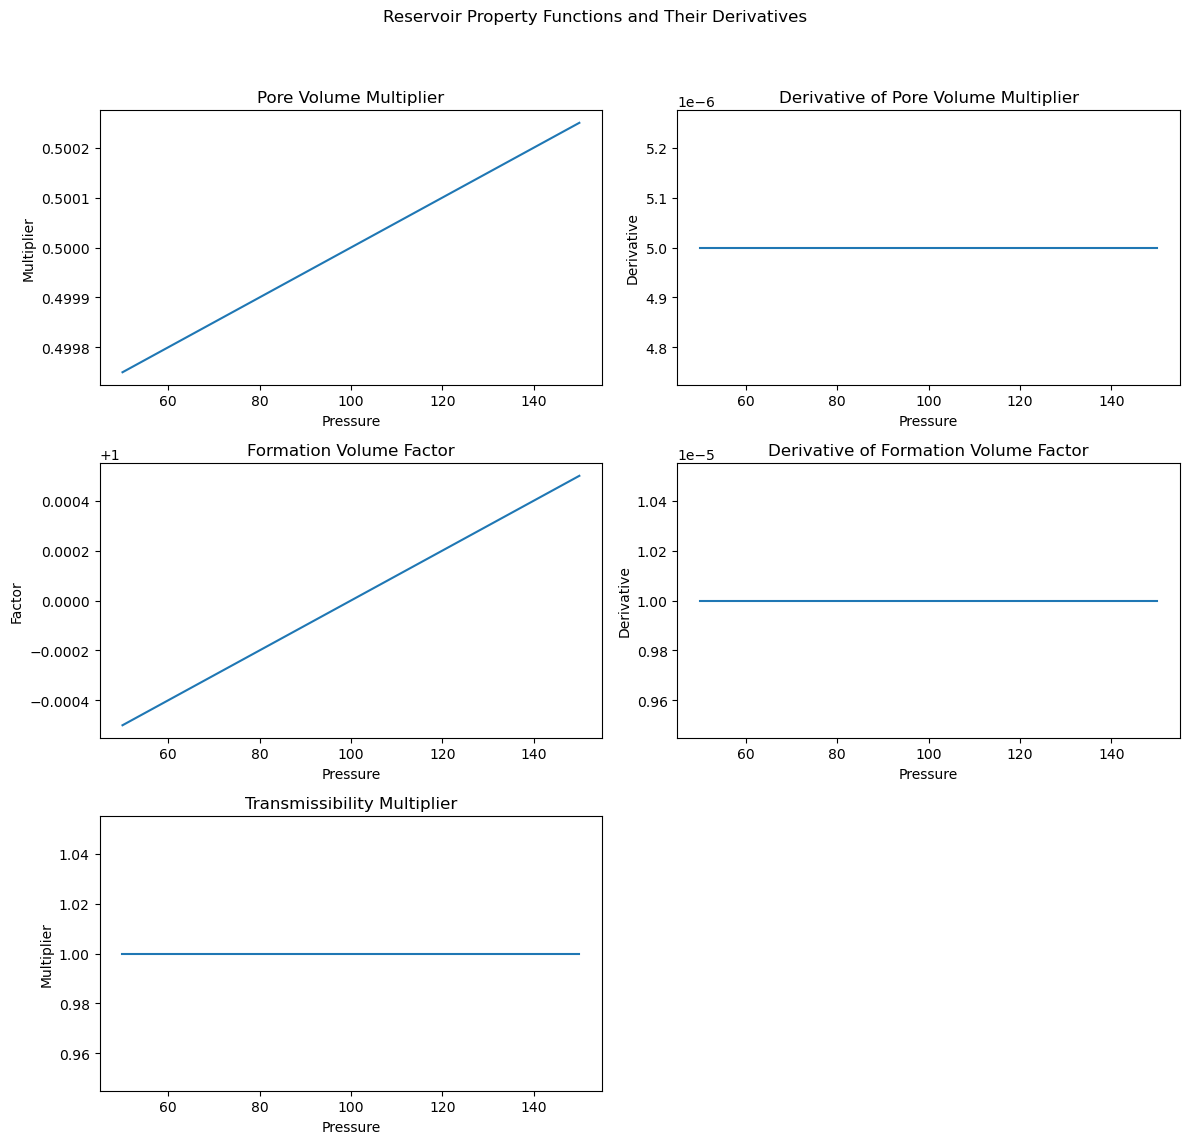

Total inflow into the well after 0.0010000000000000152 seconds is -0.004975627764236194


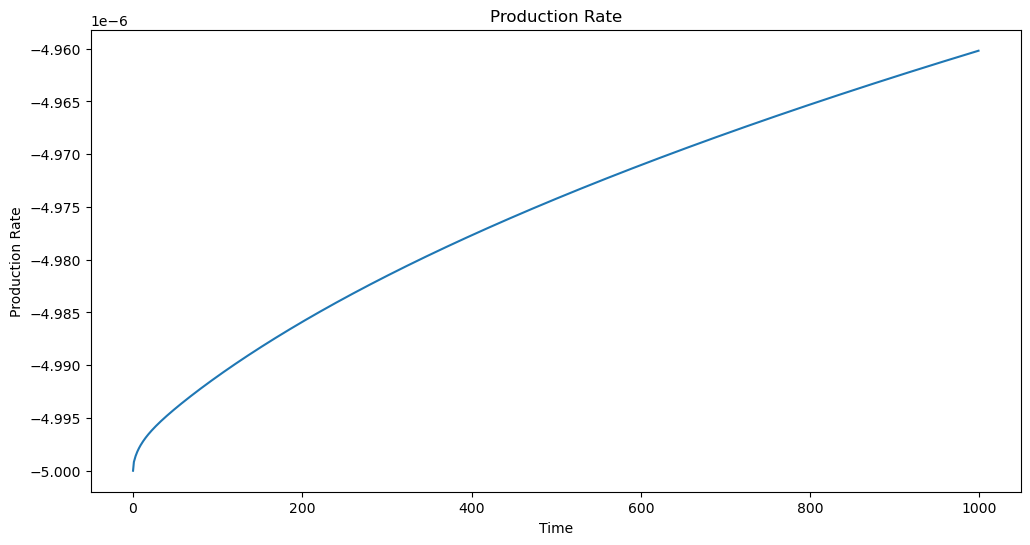

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 100
cell_volume = 0.5
V = cell_volume  # A single representative volume
p0 = 100.0  # A single representative initial pressure
compressibility = 1e-5
pressure_range = np.linspace(50, 150, 500)  # Pressure from 50 to 150 units

# Function definitions (from your code)
def pore_volume_multiplier(p, dp=False):
    if dp:
        return compressibility * V
    else:
        return V * (1 + compressibility * (p - p0))

def formation_volume_factor(p, dp=False):
    if dp:
        return compressibility
    else:
        return 1 + compressibility * (p - p0)

def transmissibility_multiplier(p, dp=False):
    return np.ones_like(p)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Reservoir Property Functions and Their Derivatives')

# Pore Volume Multiplier
axs[0, 0].plot(pressure_range, pore_volume_multiplier(pressure_range))
axs[0, 0].set_title('Pore Volume Multiplier')
axs[0, 0].set_xlabel('Pressure')
axs[0, 0].set_ylabel('Multiplier')
axs[0, 1].plot(pressure_range, [pore_volume_multiplier(p, dp=True) for p in pressure_range])
axs[0, 1].set_title('Derivative of Pore Volume Multiplier')
axs[0, 1].set_xlabel('Pressure')
axs[0, 1].set_ylabel('Derivative')

# Formation Volume Factor
axs[1, 0].plot(pressure_range, formation_volume_factor(pressure_range))
axs[1, 0].set_title('Formation Volume Factor')
axs[1, 0].set_xlabel('Pressure')
axs[1, 0].set_ylabel('Factor')
axs[1, 1].plot(pressure_range, [formation_volume_factor(p, dp=True) for p in pressure_range])
axs[1, 1].set_title('Derivative of Formation Volume Factor')
axs[1, 1].set_xlabel('Pressure')
axs[1, 1].set_ylabel('Derivative')

# Transmissibility Multiplier
axs[2, 0].plot(pressure_range, transmissibility_multiplier(pressure_range))
axs[2, 0].set_title('Transmissibility Multiplier')
axs[2, 0].set_xlabel('Pressure')
axs[2, 0].set_ylabel('Multiplier')
axs[2, 1].axis('off')  # Empty since the function is currently a constant

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




# Initialize parameters
n = 100  # Number of grid cells
cell_volume = 0.5  # Cell volume
poro = np.ones(n) * 0.3  # Porosity
V = np.ones(n) * cell_volume  # Volume
lam = 1.0  # Mobility
p0 = np.full(n, 10000.0)  # Initial pressure

# Well information
w = np.zeros(n)
w[5] = 1
well_mobility = np.ones(n) * 0.5
well_transmissibility = np.ones(n) * 0.001

# Compressibility and other factors
compressibility = 1e-5  # Compressibility term

# Connectivity Matrix
T = np.zeros((n, n))
np.fill_diagonal(T[:-1, 1:], 1)
np.fill_diagonal(T[1:, :-1], 1)

# Update pressure
def update_pressure(p, A, B, C, dt):
    epsilon = 1e-9
    A_reg = A + np.eye(A.shape[0]) * epsilon
    try:
        dpt = np.linalg.solve(A_reg, -B - C)
    except np.linalg.LinAlgError as e:
        print("Matrix is singular:", e)
        return p
    return p + dt * dpt


# Initialize total inflow
total_inflow = 0

# Time-stepping
dt = 1e-6  # Time step
p = p0.copy()  # Current pressure
t = 0  # Current time

prod_rate = []
for k in range(1000):
    A = np.diag(poro * pore_volume_multiplier(p, dp=True) * formation_volume_factor(p) + 
                poro * pore_volume_multiplier(p) * formation_volume_factor(p, dp=True))
    
    pi_pj = p[:, None] - p
    B = np.sum(T * formation_volume_factor(p) * lam * transmissibility_multiplier(p) * pi_pj, axis=1)
    
    pbhp = p.copy()
    pbhp[5] = 0
    C = well_mobility * well_transmissibility * (p - pbhp)
    
    # Update inflow for the well
    q = - well_mobility[5] * well_transmissibility[5] * (p[5] - pbhp[5])
    total_inflow += q * dt
    prod_rate.append(q*dt)
    
    p = update_pressure(p, A, B, C, dt)
    t += dt

print("Total inflow into the well after {} seconds is {}".format(t, total_inflow))

# plot prod_rate with title and xlabel and ylabel
fig = plt.figure(figsize=(12, 6))
plt.plot(prod_rate)
plt.title('Production Rate')
plt.xlabel('Time')
plt.ylabel('Production Rate')
plt.show()


## An Implicit Solution to the Governing Equation for Discretized Water Flow in a Porous Medium

The equation governing the transient behavior of water flow in a discretized porous medium can be described as follows:

$$
\begin{equation}
\underbrace{\Big[\Phi_{\text{ref}} V \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right) \frac{dp}{dt} \Big]_i}_{\text{Transient term in block }i, \, \left[\frac{m^3}{s} \right]}
+ \underbrace{\sum_{j \in C(i)} \left[ \left[b(p) \lambda m_T(p) \right]_i T_{ij} (p_{i} - p_{j}) \right]}_{\text{Flow between connected blocks}, \, \left[\frac{m^3}{s} \right]}
+ \underbrace{T_{w,i}M_{i} (p_i - p_{bhp,w})}_{\text{Inflow into well within block }i, \, \left[\frac{m^3}{s} \right]} = 0
\end{equation}
$$

### Time Discretization

To solve this equation in a transient manner, we discretize it in time. We introduce a time index $ t $ for pressure $ p $ to indicate that the pressure is a function of time, denoted as $ p^t $. The reformulated residual equation $ R_i(p) $ thus becomes:

$$
\begin{align*}
R_i(p^t) &= \Phi_{\text{ref}} V \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right)|_{p=p^t} \frac{p^t - p^{t-1}}{\Delta t} \\
&+ \sum_{j \in C(i)} \left. \left[ b(p) \lambda m_T(p) \right]_i \right|_{p=p^t} T_{ij} (p_i^t - p_j^t) \\
&+ T_{w,i}M_{i} (p_i^t - p_{bhp,w}) \\
&= 0
\end{align*}
$$

### Algorithm for Numerical Solution

1. **Initialization**: Initialize $ p^0 $, the initial pressure distribution at $ t=0 $.

2. **Time Stepping**: For each time step $ t = 1, 2, \ldots $:

    - **Set Previous Pressure**: $ p^{t-1} \gets p^t $
    
    - **Newton-Raphson Loop for $ t $**
    
        1. **Compute Residual**: Calculate $ R_i(p^t) $ based on the time-discretized equation.
        
        2. **Compute Jacobian**: Formulate the Jacobian matrix $ J = \left[\frac{\partial R_i}{\partial p_j}\right] $ by differentiating $ R_i(p^t) $.
        
        3. **Pressure Update**: Solve $ \Delta p = -J^{-1} R $ to obtain $ \Delta p $, and then update $ p^t \gets p^t + \Delta p $.
        
        4. **Check Convergence**: If $ R $ or $ \Delta p $ falls below a specified tolerance, the solution has converged. Set $ p_t = p^t $. Otherwise, repeat the Newton-Raphson loop.

### Nomenclature with Units

- $ \Phi_{\text{ref,i}} $: Reference porosity in cell $ i $, dimensionless.
- $ V_i $: Volume of cell $ i $, $ m^3 $.
- $ m_{\phi,i} $: Pore volume multiplier in cell $ i $, dimensionless.
- $ b_i $: Formation volume factor; relates reservoir to surface volume, $ m^3/m^3 $.
- $ C(i) $: Set of cells connected to cell $ i $.
- $ \lambda $: Mobility of the water phase, $ m^2/\text{Pa} \cdot s $.
- $ m_{T,i} $: Transmissibility multiplier in cell $ i $, dimensionless.
- $ T_{ij} $: Transmissibility factor between cells $ i $ and $ j $, $ m^2/\text{Pa} \cdot s $.
- $ p_i $: Pressure in cell $ i $, Pa.
- $ T_{w,i} $: Transmissibility of the well connection in cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ M_{i} $: Mobility of the water phase in the well connection at cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ p_{bhp,w} $: Bottomhole pressure of the well, Pa.

In [84]:
# Constants
P_MAX = 10000.0
COMPRESSIBILITY = 1e-5
cell_volume = 0.5
n = 100
well_loc = 50
poro = torch.ones(n) * 0.3
V = torch.ones(n) * cell_volume
lam = 1.0
well_mobility = torch.ones(n) * 0.5
well_transmissibility = torch.ones(n) * 0.001

# Initial pressure
p = torch.full((n,), P_MAX, dtype=torch.float64, requires_grad=True)
p_last = torch.full((n,), P_MAX, dtype=torch.float64, requires_grad=False)

# Connectivity Matrix
T = torch.zeros((n, n), dtype=torch.float64)
T[:-1, 1:] = 1
T[1:, :-1] = 1

# Functions
def pore_volume_multiplier(p, V, dp=False):
    if dp:
        return COMPRESSIBILITY * V
    else:
        return V * (1 + COMPRESSIBILITY * (p - P_MAX))

def formation_volume_factor(p, dp=False):
    if dp:
        return COMPRESSIBILITY
    else:
        return 1 + COMPRESSIBILITY * (p - P_MAX)

def transmissibility_multiplier(p):
    return torch.ones_like(p)

def F(p, p_last):
    dp_dt = (p - p_last) / dt
    A = torch.diag(poro * pore_volume_multiplier(p, V, dp=True) * formation_volume_factor(p) + 
                poro * pore_volume_multiplier(p, V) * formation_volume_factor(p, dp=True))
    pi_pj = p[:, None] - p
    B = torch.sum(T * formation_volume_factor(p) * lam * transmissibility_multiplier(p) * pi_pj, axis=1)
    
    pbhp = p.clone().detach()
    pbhp[well_loc] = 0
    C = well_mobility * well_transmissibility * (p - pbhp)
    
    R = torch.matmul(A, dp_dt) + B + C
    return R


# Compute Jacobian using PyTorch's autograd
def compute_jacobian(x, func):
    jacobian = torch.autograd.functional.jacobian(func, x)
    return jacobian


def newton_raphson(p_old, p_last, max_iter=100, tolerance=1e-6):
    for i in range(max_iter):
        # Forward pass to compute function value
        R = F(p_old, p_last)
            
        # Compute Jacobian
        J = compute_jacobian(p_old, lambda x: F(x, p_last))

        # print(f"Shape of Jacobian J: {J.shape}")
        # print(f"Shape of Residual R: {R.shape}")

        # Solve for delta_p
        delta_p = torch.linalg.solve(J, -R.unsqueeze(1))

        # Update p using Newton-Raphson formula
        with torch.no_grad():
            p_new = p_old + delta_p.flatten()

        if torch.norm(p_new - p_old, p=2) < tolerance:
            print(f"Converged at iteration {i}")
            return p_new
        
        # Prepare for next iteration
        p_old = p_new.detach().clone().requires_grad_()
    
    print("Max iteration reached without convergence.")
    return p_new

# Time-stepping parameters
num_time_steps = 1
dt = 0.1

# Initialize pressure history
p_history = [p.clone().detach()]

# Main time-stepping loop
for t in range(1, num_time_steps + 1):
    print(f"Time step {t}")
    
    # Get pressure distribution from the last time step
    p_last = p_history[-1]

    # Solve for new pressure distribution using Newton-Raphson
    p_new = newton_raphson(p.clone().detach().requires_grad_(), p_last)

    # Store the new pressure distribution
    p_history.append(p_new.clone().detach())

    # Update current pressure for the next time step
    p = p_new


Time step 1
Max iteration reached without convergence.


## Newton-Raphson Method 1D Example

Let's tackle the problem of finding the root of a simple 1D equation $ f(x) = x^2 - 4 $ using the Newton-Raphson method. This equation has roots at $ x = \pm 2 $. The Newton-Raphson method starts with an initial guess and iteratively refines it using the formula:

$$
x_{\text{new}} = x_{\text{old}} - \frac{f(x_{\text{old}})}{f'(x_{\text{old}})}
$$

The algorithm stops when the difference between consecutive approximations is less than a given tolerance or after a maximum number of iterations.

### Step-by-step Implementation:

1. **Define the Function and its Derivative**: Define $ f(x) $ and $ f'(x) $.

2. **Initialize Variables**: Initialize the starting point, maximum number of iterations, and the tolerance.

3. **Newton-Raphson Iteration**: Perform the iteration until convergence is reached or the maximum number of iterations is exceeded.

Here's how you can do it in Python using PyTorch:

In this example, we initialized the starting point at $ x = 5.0 $. The iteration should ideally converge to the nearest root, $ x = 2 $, given the stopping criteria and maximum number of iterations.

This tutorial illustrates the basic workflow of using PyTorch to perform optimization tasks, in this case, root-finding using Newton-Raphson. You define your function and its derivative, and PyTorch takes care of the gradient calculations for you.

In [83]:
import torch

# Step 1: Define the function and its derivative
def f(x):
    return x ** 2 - 4

def f_prime(x):
    return 2 * x

# Step 2: Initialize variables
x_old = torch.tensor([5.0], dtype=torch.float64, requires_grad=True)  # initial guess
max_iter = 100  # maximum number of iterations
tolerance = 1e-6  # stopping criteria

# Step 3: Newton-Raphson iteration
for i in range(max_iter):
    # Forward pass to compute function value
    y = f(x_old)
    
    # Compute gradients (backward pass)
    y.backward()
    
    # Update x using Newton-Raphson formula (manual gradient descent)
    with torch.no_grad():
        x_new = x_old - y / x_old.grad
        
    # Check for convergence
    if torch.abs(x_new - x_old) < tolerance:
        print(f"Converged at iteration {i+1} with root value: {x_new.item()}")
        break

    # Prepare for the next iteration
    x_old = x_new.detach().clone().requires_grad_()
    
    # Zero-out gradients for the next iteration
    x_old.grad = None

# If not converged
else:
    print(f"Did not converge in {max_iter} iterations")

Converged at iteration 6 with root value: 2.0


## Newton-Raphson Method 2D Example

In a multidimensional context, the Newton-Raphson method generalizes to finding a vector $ \mathbf{x} $ such that $ \mathbf{F}(\mathbf{x}) = \mathbf{0} $, where $ \mathbf{F} $ is a vector-valued function. The update formula for each iteration in vector form is:

$$
\mathbf{x}_{\text{new}} = \mathbf{x}_{\text{old}} - \mathbf{J}^{-1}(\mathbf{x}_{\text{old}}) \mathbf{F}(\mathbf{x}_{\text{old}})
$$

Here, $ \mathbf{J} $ is the Jacobian matrix of $ \mathbf{F} $.

### Problem Definition

Let's consider a simple 2D problem involving two equations:

1. $ f_1(x, y) = x^2 + y^2 - 4 $
2. $ f_2(x, y) = x + y - 1 $

The vector $ \mathbf{F}(\mathbf{x}) $ then becomes:

$$
\mathbf{F}(\mathbf{x}) = \begin{bmatrix}
    f_1(x, y) \\
    f_2(x, y)
\end{bmatrix}
= \begin{bmatrix}
    x^2 + y^2 - 4 \\
    x + y - 1
\end{bmatrix}
$$

### Step-by-step Implementation:

1. **Define the Function**: Implement $ \mathbf{F}(\mathbf{x}) $ as a PyTorch function.

2. **Initialize Variables**: Initialize the starting point, maximum number of iterations, and tolerance.

3. **Newton-Raphson Iteration**: Perform the iteration.

Here is the code:


In this example, the Newton-Raphson method should converge to a root near $ \mathbf{x} = [1, 0] $, given the stopping criteria and maximum number of iterations. We used PyTorch to handle the gradient (Jacobian in this case) calculations for us, which simplifies the implementation significantly.

In [85]:
import torch

# Step 1: Define the function
def F(x):
    f1 = x[0] ** 2 + x[1] ** 2 - 4
    f2 = x[0] + x[1] - 1
    return torch.stack([f1, f2])

# Compute Jacobian using PyTorch's autograd
def compute_jacobian(x, func):
    jacobian = torch.autograd.functional.jacobian(func, x)
    return jacobian

# Step 2: Initialize variables
x_old = torch.tensor([2.0, 1.0], dtype=torch.float64, requires_grad=True)  # initial guess
max_iter = 100  # maximum number of iterations
tolerance = 1e-6  # stopping criteria

# Step 3: Newton-Raphson iteration
for i in range(max_iter):
    # Forward pass to compute function value
    y = F(x_old)
    
    # Compute Jacobian
    J = compute_jacobian(x_old, F)
    
    # Solve for the update step (delta_x)
    delta_x = torch.linalg.solve(J, -y.view(-1, 1))
    
    # Update x using Newton-Raphson formula
    with torch.no_grad():
        x_new = x_old + delta_x.flatten()
        
    # Check for convergence
    if torch.norm(x_new - x_old, p=2) < tolerance:
        print(f"Converged at iteration {i+1} with root value: {x_new.detach().numpy()}")
        break
    
    # Prepare for the next iteration
    x_old = x_new.detach().clone().requires_grad_()
    
# If not converged
else:
    print(f"Did not converge in {max_iter} iterations")


Converged at iteration 6 with root value: [ 1.82287566 -0.82287566]
